# Variational Autoencoder 

![대체 텍스트](https://drive.google.com/uc?id=1OCoK4me3T3EcaEm6H-MobpVG45LrNRrh)

## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
import numpy as np
import itertools as it
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
np.random.seed(2018)
tf.set_random_seed(2018)

## MNIST 데이터 셋 로드

In [2]:
# Load the MNIST data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)
X_train, X_test = mnist.train.images, mnist.test.images
print (X_train.shape, X_test.shape)
labels_train = mnist.train.labels
n_samples = int(mnist.train.num_examples)

W0822 00:26:15.291039 140156544329600 deprecation.py:323] From <ipython-input-2-44680a9a146b>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0822 00:26:15.300410 140156544329600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0822 00:26:15.303282 140156544329600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0822 00:26:15.713319 140156544329600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0822 00:26:15.808653 140156544329600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784) (10000, 784)


## Variational Autoencoder Class 생성

![대체 텍스트](https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg)

In [0]:
class VariationalAutoencoder(object):
    def __init__(self, n_layers=[784, 500, 500, 2], transfer_fct=tf.nn.softplus, learning_rate=0.001, batch_size=100):
        self.n_layers = n_layers
        self.learning_rate = learning_rate
        self.transfer_fct = transfer_fct 
        self.batch_size = batch_size
        self.transfer = tf.nn.softplus 
        self.graph = tf.Graph()
        with self.graph.as_default():
            optimizer = tf.train.AdamOptimizer(learning_rate)
            network_weights = self._initialize_weights()
            self.weights = network_weights

            # model
            # encoder
            self.x = tf.placeholder(tf.float32, [None, self.n_layers[0]])
            self.hidden_encode = []
            h = self.x
            # 2개 fc층을 생성
            for layer in range(len(self.n_layers)-2):
                h = self.transfer(
                    tf.add(tf.matmul(h, self.weights['encode'][layer]['w']),
                        self.weights['encode'][layer]['b']))
                self.hidden_encode.append(h)
                
            self.z_mean = tf.add(tf.matmul(h, self.weights['mean']['w']), self.weights['mean']['b'])
            self.z_log_sigma_sq = tf.add(tf.matmul(h, self.weights['log_sigma']['w']), self.weights['log_sigma']['b'])

            # sample from gaussian distribution 
            eps = tf.random_normal(tf.stack([tf.shape(self.x)[0], self.n_layers[-1]]), 0, 1, dtype = tf.float32)
            self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
            
            # decoder
            self.hidden_recon = []
            h = self.z
            for layer in range(len(self.n_layers)-1):
                h = self.transfer(
                    tf.add(tf.matmul(h, self.weights['recon'][layer]['w']),
                        self.weights['recon'][layer]['b']))
                self.hidden_recon.append(h)
            self.reconstruction = self.hidden_recon[-1]
                       
            # cost
            # Reconstructloss
            self.reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
            # KL divergence
            self.latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                            - tf.square(self.z_mean)
                                            - tf.exp(self.z_log_sigma_sq), 1)
            self.cost = tf.reduce_mean(self.reconstr_loss + self.latent_loss)
            self.optimizer = optimizer.minimize(self.cost)

            # create a saver 
            self.saver = tf.train.Saver()
            init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(init)
    #VAE architecture 가중치및 바이어스 초기화 함수 
    def _initialize_weights(self):
        all_weights = dict()
        initializer = tf.contrib.layers.xavier_initializer()
        # Encoding network weights
        encoder_weights = []
        for layer in range(len(self.n_layers)-2):
            
            w = tf.Variable(
                initializer((self.n_layers[layer], self.n_layers[layer + 1]),
                            dtype=tf.float32))
            
            b = tf.Variable(
                tf.zeros([self.n_layers[layer + 1]], dtype=tf.float32))
            encoder_weights.append({'w': w, 'b': b})
            
        # Bottleneck layer weights
        w = tf.Variable(
            initializer((self.n_layers[-2], self.n_layers[-1]),
                        dtype=tf.float32))
       
        b = tf.Variable(
            tf.zeros([self.n_layers[-1]], dtype=tf.float32))
        all_weights['mean'] = {'w': w, 'b': b}
       
        w = tf.Variable(
            initializer((self.n_layers[-2], self.n_layers[-1]),
                        dtype=tf.float32))
       
        b = tf.Variable(
            tf.zeros([self.n_layers[-1]], dtype=tf.float32))
      
        all_weights['log_sigma'] = {'w': w, 'b': b}
      
        # Recon network weights
        recon_weights = []
        for layer in range(len(self.n_layers)-1, 0, -1):
            w = tf.Variable(
                initializer((self.n_layers[layer], self.n_layers[layer - 1]),
                            dtype=tf.float32))
           
            b = tf.Variable(
                tf.zeros([self.n_layers[layer - 1]], dtype=tf.float32))
          
            recon_weights.append({'w': w, 'b': b})
        all_weights['encode'] = encoder_weights
        all_weights['recon'] = recon_weights
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X})

    def calc_losses(self, X):
        reconstr_loss, latent_losses = self.sess.run([self.reconstr_loss, self.latent_loss], feed_dict={self.x: X})
        return reconstr_loss, np.mean(latent_losses)
   
    def fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost),feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.randn(1, self.n_layers[-1])
        return self.sess.run(self.reconstruction, feed_dict={self.z: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x: X})

    def save(self, path):
        '''To save trained model and its params.
        '''
        save_path = self.saver.save(self.sess, 
            os.path.join(path, 'model.ckpt'))
        # save parameters of the model
        params = {'n_layers': self.n_layers, 'learning_rate': self.learning_rate}
        json.dump(params, 
            open(os.path.join(path, 'model_params.json'), 'w'))
        return save_path

    def _restore(self, path):
        with self.graph.as_default():
            self.saver.restore(self.sess, path)

    @classmethod
    def load(cls, path):
        '''To restore a saved model.
        '''
        # load params of the model
        params = json.load(open(os.path.join(path, 'model_params.json'), 'r'))
        # init an instance of this class
        estimator = cls(**params)
        estimator._restore(os.path.join(path, 'model.ckpt'))
        return estimator

# Train함수 생성 및 VAE 모델 훈련
###2개의 Latent Space를 가진 VAE모델을 훈련시킵니다.

In [6]:
 
def train(learning_rate=0.001, batch_size=100, training_epochs=10, display_step=20):
    vae = VariationalAutoencoder(learning_rate=learning_rate,batch_size=batch_size)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Epoch당 로그 표시
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae
  
vae2d = train(training_epochs=900)


Epoch: 0001 cost= 2309.142372603
Epoch: 0021 cost= 1474.893932218
Epoch: 0041 cost= 1403.778769087
Epoch: 0061 cost= 1358.645233709
Epoch: 0081 cost= 1333.783920676
Epoch: 0101 cost= 1317.856892090
Epoch: 0121 cost= 1299.822609197
Epoch: 0141 cost= 1289.287265403
Epoch: 0161 cost= 1274.888357599
Epoch: 0181 cost= 1268.458063299
Epoch: 0201 cost= 1260.194422718
Epoch: 0221 cost= 1252.556743830
Epoch: 0241 cost= 1246.724182351
Epoch: 0261 cost= 1239.824930753
Epoch: 0281 cost= 1235.396062456
Epoch: 0301 cost= 1230.458389560
Epoch: 0321 cost= 1226.309510942
Epoch: 0341 cost= 1221.552633390
Epoch: 0361 cost= 1217.270765714
Epoch: 0381 cost= 1213.328366477
Epoch: 0401 cost= 1209.935056929
Epoch: 0421 cost= 1208.305304066
Epoch: 0441 cost= 1206.198302113
Epoch: 0461 cost= 1201.211711204
Epoch: 0481 cost= 1199.255120073
Epoch: 0501 cost= 1196.068415305
Epoch: 0521 cost= 1193.582044123
Epoch: 0541 cost= 1189.457595659
Epoch: 0561 cost= 1188.126994407
Epoch: 0581 cost= 1184.834036088
Epoch: 060

## Reconstruction 결과확인
### x와 x'를 출력하여 얼마나 잘 복원됐는지 확인합니다.  

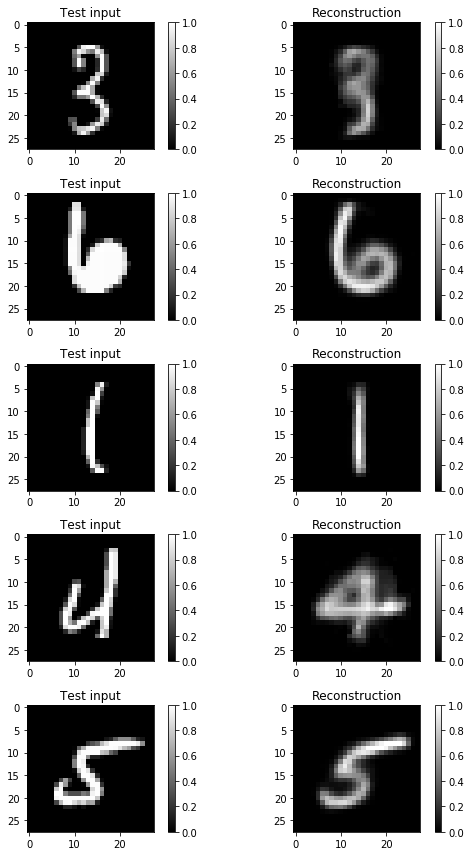

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae2d.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Visualization 관련 함수 생성

In [0]:
def display_mnist_image(x, figsize=None):
    '''x is an array with shape (1, 784)'''
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(x.reshape(28, 28), cmap="gray")
    ax.set_axis_off()
    return ax

def display_mnist_images(xs, figsize=None):
    '''xs is a list of arrays with shape (1,784)'''
    n = len(xs)
    canvas = np.empty((28, 28*n))
    for i, x in enumerate(xs):
        # scale to (0, 1)
        x = preprocessing.minmax_scale(x.T).T
        canvas[:, i*28: (i+1)*28] = x[0].reshape(28, 28)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(canvas, cmap="gray")
    ax.set_axis_off()
    return ax
def interpolate_from_a_to_b(Z, labels, generator, a, b, 
                            alphas=np.linspace(-3, 3, 10),
                            figsize=(14,5)
                           ):
    '''Interpolation between two classes a and b.
    Z: np.array of the latent space with shape: (n_samples, latent_dim)
    labels: array of class labels (n_samples, ) 
    '''
    # Find the centroids of the classes a, b
    z_a_avg = Z[labels == a].mean(axis=0)
    z_b_avg = Z[labels == b].mean(axis=0)
    # Pick the medoid for class a for interpolation
    z_a_med = np.median(Z[labels == a], axis=0)
    # The interpolation vector pointing from b -> a
    z_b2a = z_a_avg - z_b_avg

    x_gens = []
    for alpha in alphas:
        z_interp = z_a_med + alpha * z_b2a
        x_gens.append(generator.generate(z_interp.reshape(1, -1)))

    ax = display_mnist_images(x_gens, figsize=figsize)
    return ax, x_gens


## Visualization(Latent space)
### 훈련된 VAE의 2D Latent Space 위치해 있는 MNIST의 Manifold를 출력합니다. 

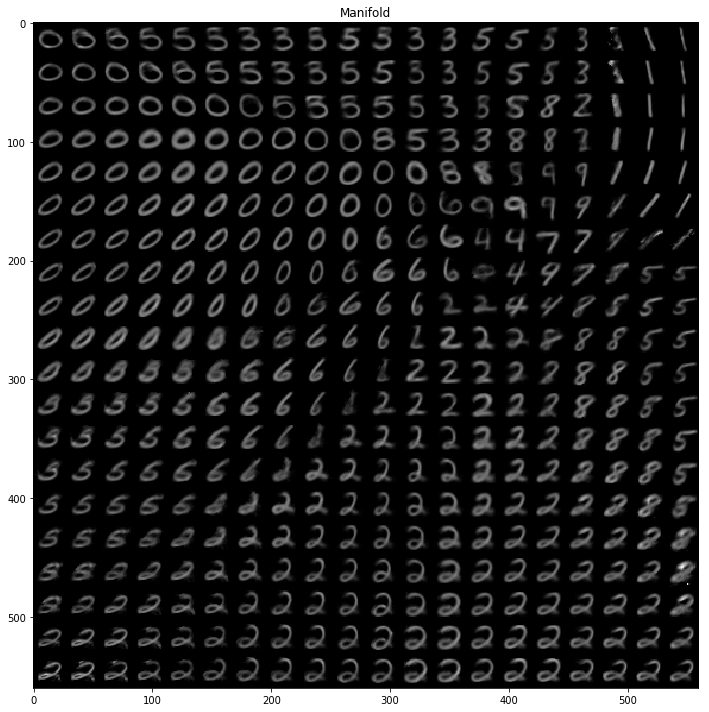

In [76]:
nx = ny =20
x_values = np.linspace(-9, 3, nx)
y_values = np.linspace(-9, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae2d.batch_size)
        x_mean = vae2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(10, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.title("Manifold")
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

### MNIST의 Latent Space에서 데이터 a,b의 Interpolation을 수행합니다. (a -> b)
### 알파값을 잘 조정해야 합니다.

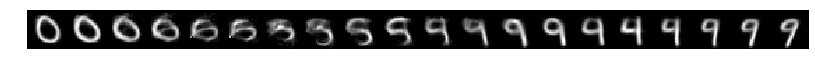

In [74]:
Z_test_vae2d = vae2d.transform(X_test)
a = 0
b = 9
alphas = np.linspace(-9, 3, 20)
ax, x_gens = interpolate_from_a_to_b(Z_test_vae2d, mnist.test.labels, vae2d, 
                                  a,b,alphas=alphas)

In [77]:
print(np.shape(Z_test_vae2d))
print(np.shape(mnist.test.labels))

(10000, 2)
(10000,)


## Reference
-------
*   https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
*   https://nbviewer.jupyter.org/github/wangz10/Generative-Models/blob/master/Main.ipynb?source=post_page

